In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict


In [2]:
def try_numeric(item):
    item = item.replace("%","").strip()
    item = item.replace("percent","").strip()
    item = item.replace("trainset","").strip()
    item = item.replace("tonne","").strip()
    item = item.replace("kg","").strip()
    item = item.replace("gramme","").strip()
    item = item.replace("kilogramme","").strip()
    item = item.replace("metre","").strip()
    item = item.replace("kilometre","").strip()

    try:
        tmp = int(item)
        return True
    except:

        try:
            tmp = float(item)
            return True
        except:
            return False

def maybe_split(keys):
    split = keys.split("[SEP]")
    if len(split) == 2:
        return split[0].strip(),split[1].strip(), None
    elif len(split) == 3:
        return [s.strip() for s in split[:3]]

def convert_comparable(item):
    if try_numeric(item):
        item = item.replace("%", "").strip()
        item = item.replace("percent", "").strip()
        item = item.replace("trainset", "").strip()
        item = item.replace("tonne", "").strip()
        item = item.replace("kg", "").strip()
        item = item.replace("gramme", "").strip()
        item = item.replace("kilogramme", "").strip()
        item = item.replace("metre", "").strip()
        item = item.replace("kilometre", "").strip()

        return float(item.replace("numeric",""))
    else:
        return item

def generate_answers(question_text, question_type, question_facts):
    assert all(q["qid"].startswith(question_type) for q in question_facts)
    answer_keys = dict()
    if question_type== "argmin":
        # get all keys and find the key with the smallest count
        answers = defaultdict(list)
        numeric_answers = False
        for question in question_facts:
            if question["symmetric"]:
                ak = None
                k, v = question["generated"]["derivation"].split("[SYM]" if "[SYM]" in question["generated"]["derivation"] else "[SEP]")
            else:
                k, v, ak = maybe_split(question["generated"]["derivation"])
            assert "[SEP]" not in k
            assert "[SEP]" not in v

            if try_numeric(v):
                numeric_answers = True

            try:
                if isinstance(convert_comparable(v.strip()),str) and numeric_answers:
                    continue
                answers[k.strip()].append((convert_comparable(v.strip()), question))
                answer_keys[k.strip()] = ak
                    
                
                if question["symmetric"]:
                    answers[v.strip()].append((convert_comparable(k.strip()), question))
            except:
                pass

        if not len(answers):
            return [None]
        else:
            if not numeric_answers:
                best = sorted(answers.items(), key=lambda a: len(a[1]), reverse=False)
                lowest = len(best[0][1])
                best_answers = {k: v for k, v in best if len(v) == lowest}
            else:
                best = sorted(filter(lambda a: not isinstance(a[1][0][0],str), answers.items()), key=lambda a: a[1][0][0], reverse=False)
                lowest = best[0][1][0]
                best_answers = {k: v for k, v in best if v[0] == lowest}
            return list([answer_keys[k] if k in answer_keys and answer_keys[k] is not None else k for k in best_answers.keys()])


    elif question_type== "argmax":
        # get all keys and find the key with the smallest count
        answers = defaultdict(list)

        numeric_answers = False
        for question in question_facts:
            if question["symmetric"]:
                ak = None
                k, v = question["generated"]["derivation"].split("[SYM]" if "[SYM]" in question["generated"]["derivation"] else "[SEP]")
            
            else:
                k, v, ak = maybe_split(question["generated"]["derivation"])
            assert "[SEP]" not in k
            assert "[SEP]" not in v

            if try_numeric(v):
                numeric_answers = True

            try:
                if question["symmetric"]:
                    answers[v.strip()].append((convert_comparable(k.strip()), question))
                answers[k.strip()].append((convert_comparable(v.strip()), question))
                answer_keys[k.strip()] = ak

                if question["symmetric"]:
                    answers[v.strip()].append((convert_comparable(k.strip()), question))
            except:
                pass

        if not len(answers):
            return [None]
        else:
            if not numeric_answers:
                best = sorted(answers.items(), key=lambda a: len(a[1]), reverse=True)
                highest = len(best[0][1])
                best_answers = {k: v for k, v in best if len(v) == highest}
            else:
                
                best = sorted(filter(lambda a: not isinstance(a[1][0][0],str), answers.items()), key=lambda a: a[1][0][0], reverse=True)
                highest = best[0][1][0]
                best_answers = {k: v for k, v in best if v[0] == highest}
            return list([answer_keys[k] if k in answer_keys and answer_keys[k] is not None else k for k in best_answers.keys()])


    elif question_type== "min":
        # get all keys and find the key with the smallest count
        answers = []

        for question in question_facts:
            v = question["generated"]["derivation"]
            if "[SEP]" in v:
                v = v.split("[SEP]",maxsplit=1)[1].strip()

            assert "[SEP]" not in v, v
            if try_numeric(v):
                answers.append(convert_comparable(v))

        best = np.min(answers) if len(answers) else None
        return [best]


    elif question_type== "max":
        # get all keys and find the key with the smallest count
        answers = []

        for question in question_facts:
            v = question["generated"]["derivation"]
            if "[SEP]" in v:
                v = v.split("[SEP]",maxsplit=1)[1].strip()

            assert "[SEP]" not in v, v
            if try_numeric(v):
                answers.append(convert_comparable(v))

        best = np.max(answers) if len(answers) else None
        return [best]

    elif question_type== "count":
        # get all keys and find the key with the smallest count
        answers = set()

        for question in question_facts:
            v = question["generated"]["derivation"]
            assert "[SEP]" not in v, v
            answers.add(convert_comparable(v))



        best = len(answers)
        return [best]

    elif question_type== "bool":
        # get all keys and find the key with the smallest count
        answers = set()

        for question in question_facts:
            v = question["generated"]["derivation"]
            assert "[SEP]" not in v, v
            assert v == "TRUE" or v == "FALSE"
            answers.add(convert_comparable(v))

        return list(answers) if len(answers) else [None]

    elif question_type== "set":
        answers = set()

        for question in question_facts:
            v = question["generated"]["derivation"]
            assert "[SEP]" not in v, v
            answers.add(convert_comparable(v))

        return list(answers)

    raise Exception("Unknown quesiton type")


In [3]:
import json
import numpy as np

def precision(actual, predicted):
    actual_set = set(actual)
    return (
        sum(1.0 for p in predicted if p in actual_set) / float(len(predicted))
        if len(predicted)
        else 1.0
    )


def recall(actual, predicted):
    if len(actual) == 0:
        return 1.0

    actual_set = set(actual)
    return (
        sum(1.0 for p in predicted if p in actual_set) / float(len(actual))
        if len(actual)
        else 1.0
    )


def f1(actual, predicted):
    pr = precision(actual, predicted)
    rec = recall(actual, predicted)

    return 2.0 * pr * rec / (pr + rec) if (pr + rec > 0.0) else 0.0


def parse(answer):
    return answer


def single_score(actual, predicted, query_type):

        
    
    if query_type in {"min", "max"}:
        if actual is None and predicted is None:
            return 1.0

        if actual is not None and predicted is None:
            return 0.0

        if predicted is not None and actual is None:
            return 0.0
    
        return 1.0 if predicted[0] == actual[0] else 0.0

    elif query_type in {"argmin", "argmax", "set", "set_complex_ok", "set_complex_none", "argmin_complex_ok","argmin_complex_none","argmax_complex_ok","argmax_complex_none"}:
        
#         if "complex" not in query_type:
#             print(actual,predicted, f1(set(actual if actual is not None else []),set(predicted if predicted is not None else [])))
        return f1(set(actual if actual is not None else []),set(predicted if predicted is not None else []))

    elif query_type in {"count","count_complex_ok","count_complex_none"}:
        if predicted is None or len(predicted) > 1:
            return 0.0

        return 1.0 if predicted[0] == actual[0] else 0.0
    elif query_type in {"bool", "bool_complex_ok", "bool_complex_none"}:
        if predicted is None and actual is None:
            return 1.0
        else:
            if isinstance(actual, list) and isinstance(predicted, list):
                if len(actual) == 1 and len(predicted) == 1:
                    return 1.0 if predicted[0] == actual[0] else 0.0

            return 0.0

    return 0.0


In [61]:
breakdown = []
raw = []

seeds = [1,2,3]

all_system_size = dict()
all_system_type = dict()
all_system_bins = dict()

skipped = 0

spj = "spj_random"
splits = ["a" + l for l in ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s"]]
systems = []
for ssg in [25]:
    master_breakdown_size = defaultdict(list)
    master_breakdown_type = defaultdict(list)
    master_breakdown_bins = defaultdict(list)
    system = f"DB={ssg}, SSG+SPJ"
    systems.append(system)
    for seed in seeds:
        
    
        breakdown = defaultdict(list)
        breakdown_size = defaultdict(list)
        breakdown_bins = defaultdict(list)

        global_db_id = dict()
        by_db = defaultdict(list)
        
        for split in splits:
            
            
            print(system, seed, split)
            if not os.path.exists(f"checkpoint/checkpoint/experiment={spj}/db=v1.8_25,lr=1e-4/seed-{seed}/{ssg}_{split}_metrics_test.json"):
                continue
            with open(f"checkpoint/checkpoint/experiment={spj}/db=v1.8_25,lr=1e-4/seed-{seed}/{ssg}_{split}_metrics_test.json") as f:
                raw = []
                for line in f:
                    instance = json.loads(line)["test"]
                    raw.extend(instance["raw"])
                
                for i in raw:
                    
                    local_id = (i[3]['db_id'], i[3]["query_id"])
                    
                    if (split,local_id) not in global_db_id:
                        global_db_id[(split,local_id)] = len(global_db_id)
                        
                    master_id = global_db_id[(split,local_id)]
                    by_db[master_id].append(i)
          
 
            restored = []
            for k,v in by_db.items():

                try:

                    predicted_derivations = [{"qid": v[0][3]['type'], "symmetric": "P47" in v[0][3]['relation'],
                                              "generated": {"derivation": a[0].split(maxsplit=1)[1]}} for a in v if a[0] != "[NULL_ANSWER]" ]


                    pred = generate_answers("", v[0][3]['type'].replace("_complex","").replace("_ok","").replace("_none",""), predicted_derivations)
                except AssertionError as e:

                    skipped+=1
                    pred = [None]
                except IndexError as e:
                    pred = [None]
                except TypeError as e:
                    pred = [None]
                except ValueError as e:
                    pred = [None]

                target_derivations = v[0][3]["answer"]
                restored.append((pred,target_derivations,None,v[0][3]))


        


            for predicted,actual,_,metadata in restored:

                predicted = parse(predicted)
                actual = parse(actual)

                try:
                    local_score = single_score(actual, predicted, metadata["type"])
                except IndexError as e:
                    raise e

                breakdown[metadata["type"].replace("arg","").replace("min","mmx").replace("max","mmx").replace("mmx","min/max").replace("_ok","").replace("_none","")].append(local_score)
                breakdown_size[0 if len(actual) and None in actual else len(metadata["facts"])].append(local_score)
                

        for k,v in breakdown_size.items():
            master_breakdown_size[k].append(np.mean(v))

        for k,v in breakdown.items():
            master_breakdown_type[k].append(np.mean(v))  

        for k,v in breakdown_bins.items():
            master_breakdown_bins[k].append(np.mean(v))  

    all_system_type[system] = master_breakdown_type
    all_system_size[system] = master_breakdown_size
    all_system_bins[system] = master_breakdown_bins
    
    json.dumps({"size": all_system_size, 
            "type": all_system_type, 
            "bins": {}})

    


#     plt.title(f"Accuracy by support set size {system}")
#     plt.bar(list(master_breakdown_size.keys()), list(np.mean(k) for k in master_breakdown_size.values()),yerr=list(np.std(k) for k in master_breakdown_size.values()))
#     plt.show()

#     plt.title(f"Accuracy by type {system}")
#     plt.bar(list(master_breakdown_type.keys()), list(np.mean(k) for k in master_breakdown_type.values()),yerr=list(np.std(k) for k in master_breakdown_type.values()))

#     plt.xticks(rotation=45)
#     plt.show()


json.dumps({"size": all_system_size, 
            "type": all_system_type, 
            "bins": {
                k:{"_".join(str(s) for s in a) if isinstance(a,tuple) else str(a):b for a,b in v.items()} 
                for k, v in all_system_bins.items()}})


DB=25, SSG+SPJ 1 aa
DB=25, SSG+SPJ 1 ab
DB=25, SSG+SPJ 1 ac
DB=25, SSG+SPJ 1 ad
DB=25, SSG+SPJ 1 ae
DB=25, SSG+SPJ 1 af
DB=25, SSG+SPJ 1 ag
DB=25, SSG+SPJ 1 ah
DB=25, SSG+SPJ 1 ai
DB=25, SSG+SPJ 1 aj
DB=25, SSG+SPJ 1 ak
DB=25, SSG+SPJ 1 al
DB=25, SSG+SPJ 1 am
DB=25, SSG+SPJ 1 an
DB=25, SSG+SPJ 1 ao
DB=25, SSG+SPJ 1 ap
DB=25, SSG+SPJ 1 aq
DB=25, SSG+SPJ 1 ar
DB=25, SSG+SPJ 1 as
DB=25, SSG+SPJ 2 aa
DB=25, SSG+SPJ 2 ab
DB=25, SSG+SPJ 2 ac
DB=25, SSG+SPJ 2 ad
DB=25, SSG+SPJ 2 ae
DB=25, SSG+SPJ 2 af
DB=25, SSG+SPJ 2 ag
DB=25, SSG+SPJ 2 ah
DB=25, SSG+SPJ 2 ai
DB=25, SSG+SPJ 2 aj
DB=25, SSG+SPJ 2 ak
DB=25, SSG+SPJ 2 al
DB=25, SSG+SPJ 2 am
DB=25, SSG+SPJ 2 an
DB=25, SSG+SPJ 2 ao
DB=25, SSG+SPJ 2 ap
DB=25, SSG+SPJ 2 aq
DB=25, SSG+SPJ 2 ar
DB=25, SSG+SPJ 2 as
DB=25, SSG+SPJ 3 aa
DB=25, SSG+SPJ 3 ab
DB=25, SSG+SPJ 3 ac
DB=25, SSG+SPJ 3 ad
DB=25, SSG+SPJ 3 ae
DB=25, SSG+SPJ 3 af
DB=25, SSG+SPJ 3 ag
DB=25, SSG+SPJ 3 ah
DB=25, SSG+SPJ 3 ai
DB=25, SSG+SPJ 3 aj
DB=25, SSG+SPJ 3 ak
DB=25, SSG+SPJ 3 al


'{"size": {"DB=25, SSG+SPJ": {"3": [0.8880212014134277, 0.8908244994110719, 0.8868197879858657], "7": [0.8671089733919722, 0.8645000664008057, 0.8674106780231384], "2": [0.8570810914681014, 0.850003202664617, 0.8541186266974122], "11": [0.8724139613599768, 0.8715492733487591, 0.8705726150456228], "8": [0.8395528884443703, 0.8328063936582023, 0.8344432405400901], "0": [1.0, 1.0, 1.0], "4": [0.8891759379337019, 0.8766284440197484, 0.8872591176939003], "13": [0.8085031653057637, 0.7873262188310906, 0.822298253893346], "5": [0.8833507459950879, 0.8847075589281131, 0.8743809340518347], "14": [0.9438923395445135, 0.9584826405478578, 0.9565734989648034], "10": [0.8851582792207792, 0.8606633297258297, 0.8875193903318903], "1": [0.9565768256162174, 0.9564904399907855, 0.9552810412347384], "6": [0.8730602177446032, 0.8517812198875322, 0.8550639283197423], "9": [0.8447896584111917, 0.8254733303672944, 0.8357465355018373], "12": [0.8283469616802951, 0.7950136283469617, 0.8448078670300893], "15": [

{'DB=25, SSG+SPJ': {'2_5': [0.8685872705246482,
   0.8622700587084149,
   0.8641617742987606],
  '5_10': [0.8692944121281102, 0.860085410577752, 0.8607153949057669],
  '10_20': [0.8844233731795668, 0.8734246660749011, 0.8888966564992483],
  '0_1': [1.0, 1.0, 1.0],
  '1_2': [0.9577080491132333, 0.9577080491132333, 0.9565143246930423],
  '20': [0.875, 0.875, 0.875]}}

DB=25, SSG+SPJ [0.872744448719888, 0.9987154784842646, 0.9008620689655172, 0.8906597106597106] [0.004628892878797538, 0.000908293874356524, 0.0, 0.00029508214777735557]


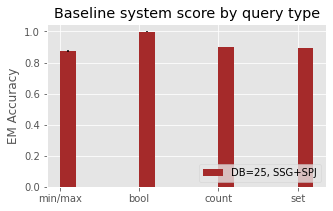

In [59]:
plt.style.use('ggplot')

labels = ['min/max','min/max_complex', 'bool', 'bool_complex', 'count', 'count_complex', 'set', 'set_complex']
labels = ['min/max', 'bool', 'count', 'set']
plt.rcParams["figure.figsize"] = (5,3)
scores = []
for system in systems:
    
    score = []
    for label in labels:
        score.append(all_system_type[system][label])

    scores.append(score)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
ptr = -1*len(systems)*width/2+width

colors = ["brown","red","orange","yellow"]

for color, score, system in zip(colors,scores,systems):
    
    print(system, [np.mean(s) for s in score], [np.std(s) for s in score])
    rects1 = ax.bar(x + ptr, [np.mean(s) for s in score], width, color=color, yerr=[np.std(s) for s in score], label=system)
    ptr += width
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EM Accuracy')
ax.set_title('Baseline system score by query type')
plt.xticks(x,rotation=0)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.savefig("baseline_type.pdf")

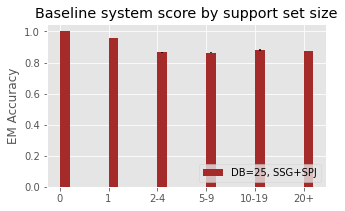

In [42]:
plt.style.use('ggplot')

ranges = [0,1,2,5,10,20]
labels = ["0","1","2-4","5-9","10-19","20+"]
s_bins = []
for idx,r in enumerate(ranges[:-1]):
    s_bins.append((ranges[idx],ranges[idx+1]))
    
s_bins.append(20)
plt.rcParams["figure.figsize"] = (5,3)
scores = []
for system in systems:
    score = []
    for sbin in s_bins:
        local = []
        score.append(all_system_bins[system][sbin])

    scores.append(score)
    

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
ptr = -1*len(systems)*width/2+width

colors = ["brown","red","orange","yellow"]

for color, score, system in zip(colors,scores,systems):
    rects1 = ax.bar(x + ptr, [np.mean(s) for s in score], width, color=color, yerr=[np.std(s) for s in score], label=system)
    ptr += width
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EM Accuracy')
ax.set_title('Baseline system score by support set size')
plt.xticks(x,rotation=0)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.savefig("baseline_size.pdf")